In [2]:
import warnings
warnings.filterwarnings("ignore")
from evaluation.mol_structure import list_of_smiles_to_nx_graphs,list_of_nx_graphs_to_smiles,smiles_to_mol
from evaluation.mol_structure import draw_one_mol, draw_graphs
from evaluation.new_structural_metric import symmetric_graph_set_distance,atom,cycle,neighborhood
from evaluate import evaluate
#import utils.graph_generators as gen
import torch
import networkx as nx
import os 
import sys
import json
current = os.getcwd()
parent = os.path.dirname(current)
sys.path.append(parent)
from rdkit.Chem import Draw
import numpy as np
from evaluation.utils import get_data,  get_mock_data,remove_empty_graphs_and_targets,\
    get_generated_data,preprocess


In [2]:
ls

 Volume in drive C is OSDisk
 Volume Serial Number is 1AD5-DE04

 Directory of c:\Users\cs843\Documents\PhD\2023\Proposal\GGM-metrics

21/07/2023  17:36    <DIR>          .
21/07/2023  17:36    <DIR>          ..
13/02/2023  13:32             1,920 .gitignore
23/04/2023  17:09    <DIR>          .venv
21/07/2023  17:29    <DIR>          __pycache__
09/05/2023  13:05            41,418 add_metrics.ipynb
23/07/2023  00:16           419,492 compare generators.ipynb
13/02/2023  13:32             7,965 config.py
13/02/2023  13:32             2,578 create_bash_script.py
05/07/2023  20:46    <DIR>          data
17/07/2023  23:27         1,819,873 data_visualization - Copy.ipynb
11/07/2023  15:51             4,724 evaluate.py
21/07/2023  17:32    <DIR>          evaluation
13/02/2023  13:33    <DIR>          experiment_results
13/02/2023  13:32             6,804 GIN_train.py
21/07/2023  18:02         1,188,955 graph_set_similarities copy.ipynb
21/07/2023  18:02         1,374,267 graph_set_similari

lipophilicity_astrazeneca_50 swingnn
{'dataset': 'lipophilicity_astrazeneca_50', 'generator_name': 'swingnn'}
[<rdkit.Chem.rdchem.Mol object at 0x000001D894042F80>, <rdkit.Chem.rdchem.Mol object at 0x000001D894043D10>, <rdkit.Chem.rdchem.Mol object at 0x000001D8940422D0>, <rdkit.Chem.rdchem.Mol object at 0x000001D894042030>, <rdkit.Chem.rdchem.Mol object at 0x000001D894043BC0>, <rdkit.Chem.rdchem.Mol object at 0x000001D894042490>, <rdkit.Chem.rdchem.Mol object at 0x000001D894043680>, <rdkit.Chem.rdchem.Mol object at 0x000001D894041FC0>, <rdkit.Chem.rdchem.Mol object at 0x000001D894042340>, <rdkit.Chem.rdchem.Mol object at 0x000001D894043920>, <rdkit.Chem.rdchem.Mol object at 0x000001D894043990>, <rdkit.Chem.rdchem.Mol object at 0x000001D8940429D0>, <rdkit.Chem.rdchem.Mol object at 0x000001D8940426C0>, <rdkit.Chem.rdchem.Mol object at 0x000001D844BBA5E0>, <rdkit.Chem.rdchem.Mol object at 0x000001D844BBA260>, <rdkit.Chem.rdchem.Mol object at 0x000001D844BBA500>, <rdkit.Chem.rdchem.Mol ob

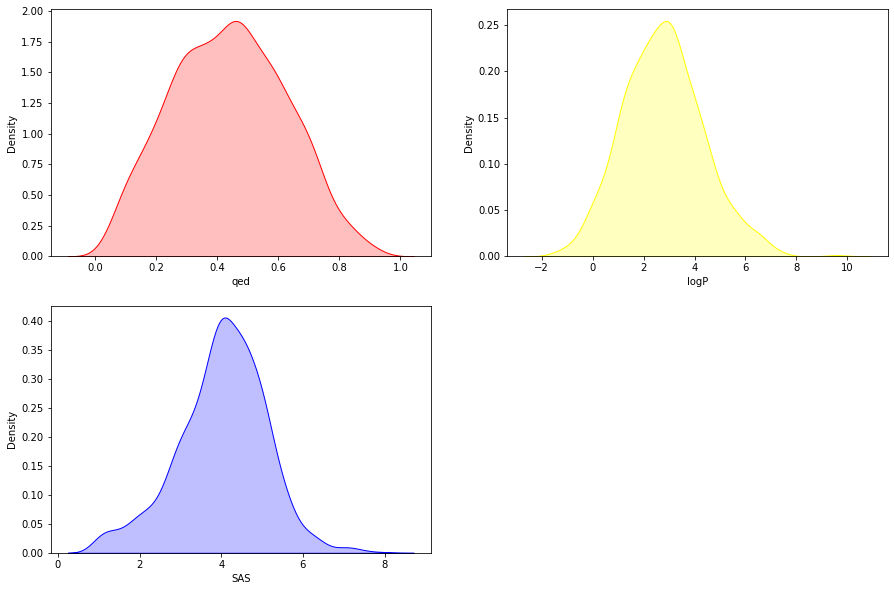

In [37]:
import seaborn as sns
from rdkit import Chem
from moses.metrics.utils  import logP, QED, SA
import rdkit
from rdkit import Chem
from evaluation.moses.metrics import get_all_metrics
import pandas as pd
from matplotlib import pyplot as plt
current_smiles_datasets=['ames']
splits=['_50']
device=torch.device('cpu')
structural_statistic=['nspdk','WL']
metrics_type=['structural']
#leave it blank to compute all the structural structures 
generators=['hiervae','wgan','stgg','moflow','gdss','jtnn','swingnn']
current_smiles_datasets=['ames', 'bbb_martins', 'cyp1a2_veith', 'cyp2c19_veith','herg_karim','lipophilicity_astrazeneca']
device=torch.device('cpu')
metrics={}
split='_50'
dataset_name='lipophilicity_astrazeneca'
generator='swingnn'
print(dataset_name+split,generator)
(train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets),smiles  =get_data(dataset_name+split, return_smiles=True)
generated_graphs, generated_targets,smiles2=get_generated_data(dataset_name+split, generator_name=generator,return_smiles=True)
splits_for_auc_roc=[train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets, generated_graphs, generated_targets]
#metrics=evaluate(train1_graphs, generated_graphs), device,  metrics_type, structural_statistic,*splits_for_auc_roc)
metrics['dataset']=dataset_name+split
metrics['generator_name']=generator
print(metrics)
data=smiles['train1_smiles']
data=smiles2
mols =[Chem.MolFromSmiles(smile)  for smile in data]
mols=[ Chem.MolFromSmiles('C')  if mol==None else mol for mol in mols]
print(mols)

log_p =[logP(mol)  for mol in mols]
qeds= [QED(mol) for mol in mols]
sas= [SA(mol) for mol in mols]
d1={'smiles':data,'logP':log_p, 'qed':qeds,'SAS':sas}
trial=pd.DataFrame(data=d1)

fig,ax=plt.subplots(2,2,figsize=(15, 10))

sns.kdeplot(trial['qed'], color="red", shade=True,ax=ax[0,0])
sns.kdeplot(trial['logP'], color="yellow", shade=True,ax=ax[0,1])
sns.kdeplot(trial['SAS'], color="blue", shade=True,ax=ax[1,0])
ax[1,1].set_axis_off()

In [38]:

#Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in sample_smiles],molsPerRow=10)
sample_smiles=list(pd.unique(trial[(trial['qed']>0.3)  & (trial['qed']<0.5 ) & (trial['logP']>2.5)  & (trial['logP']<4)   & (trial['SAS']>3) & (trial['SAS']<5)   ]['smiles'].sample(2, replace=False)))
sample_smiles=list(pd.unique(trial['smiles'].sample(50, replace=False)))
#sample_train=list_of_smiles_to_nx_graphs(sample_smiles)

In [ ]:
for smile in sample_smiles:
    try:
      if Chem.MolFromSmiles(smile)!=None:
        print(smile)
    except :None

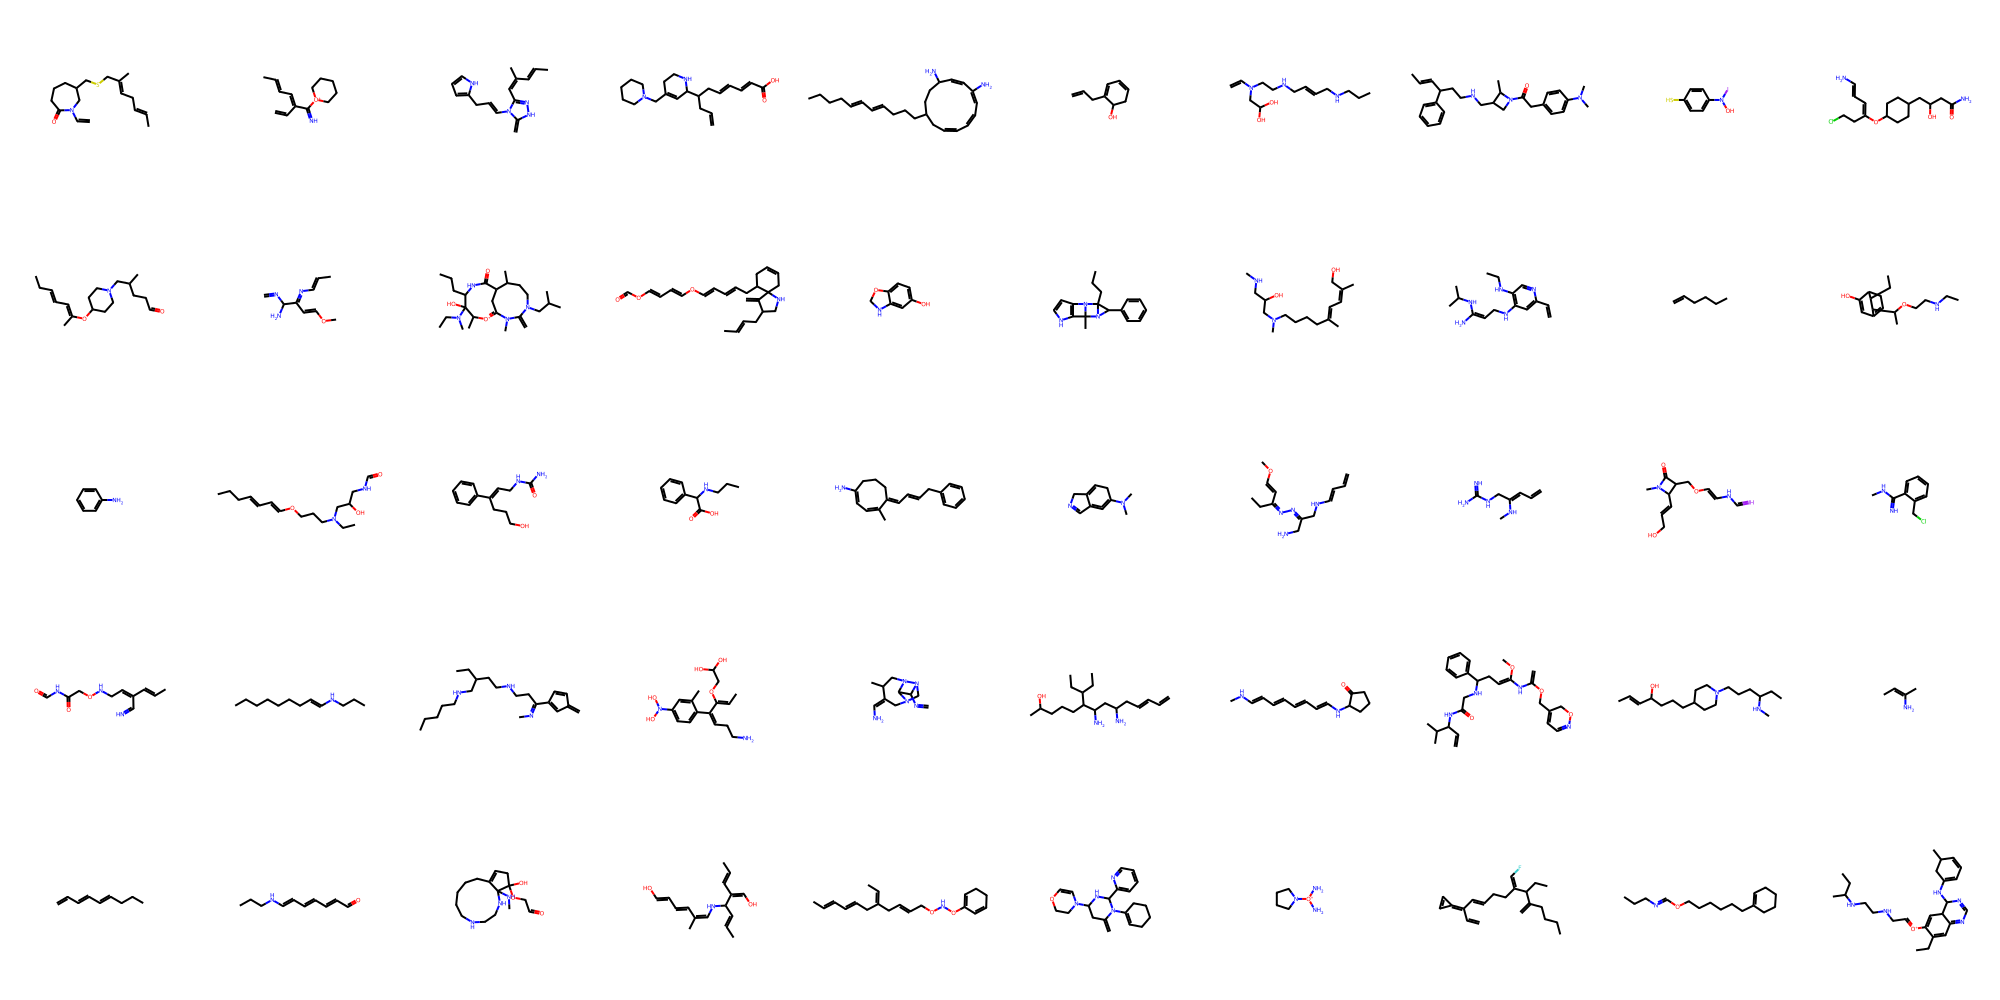

In [39]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in sample_smiles[:50]],molsPerRow=10)


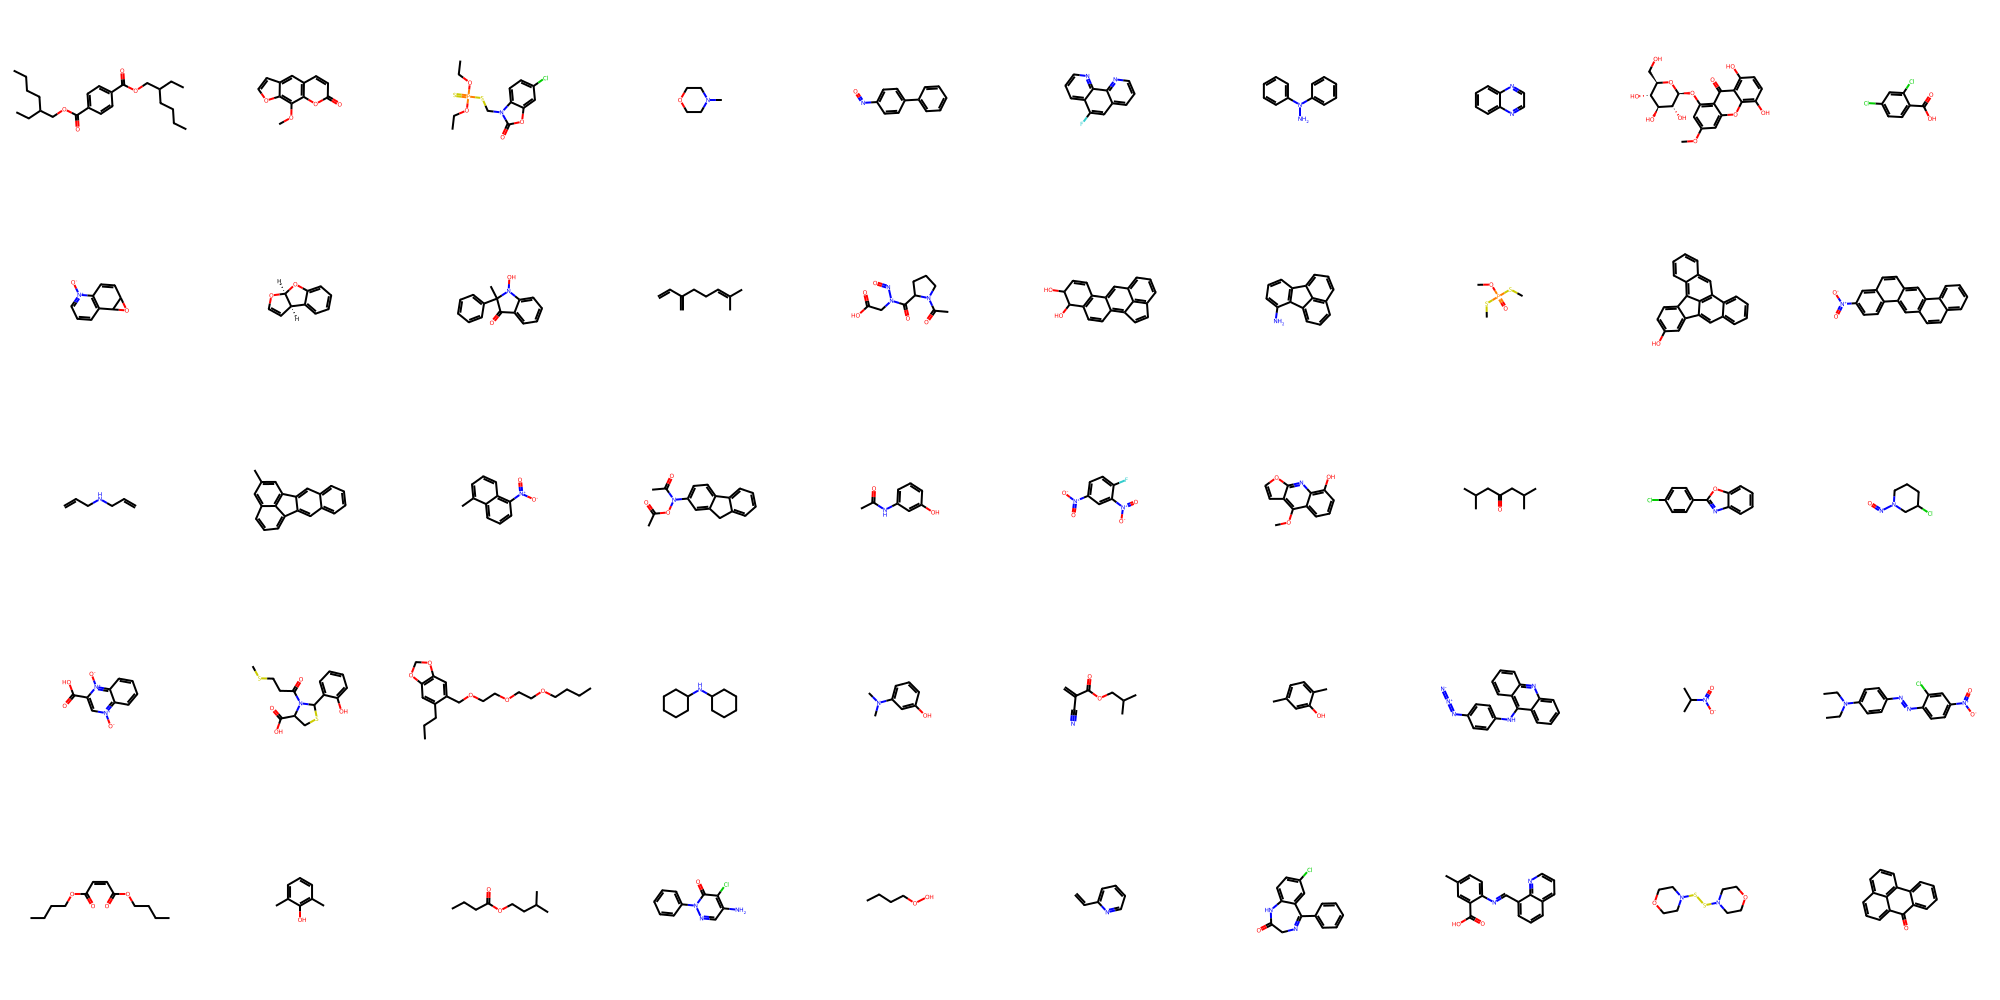

In [19]:
import rdkit
from rdkit import Chem
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in (smiles['train1_smiles'][:50])],molsPerRow=10)

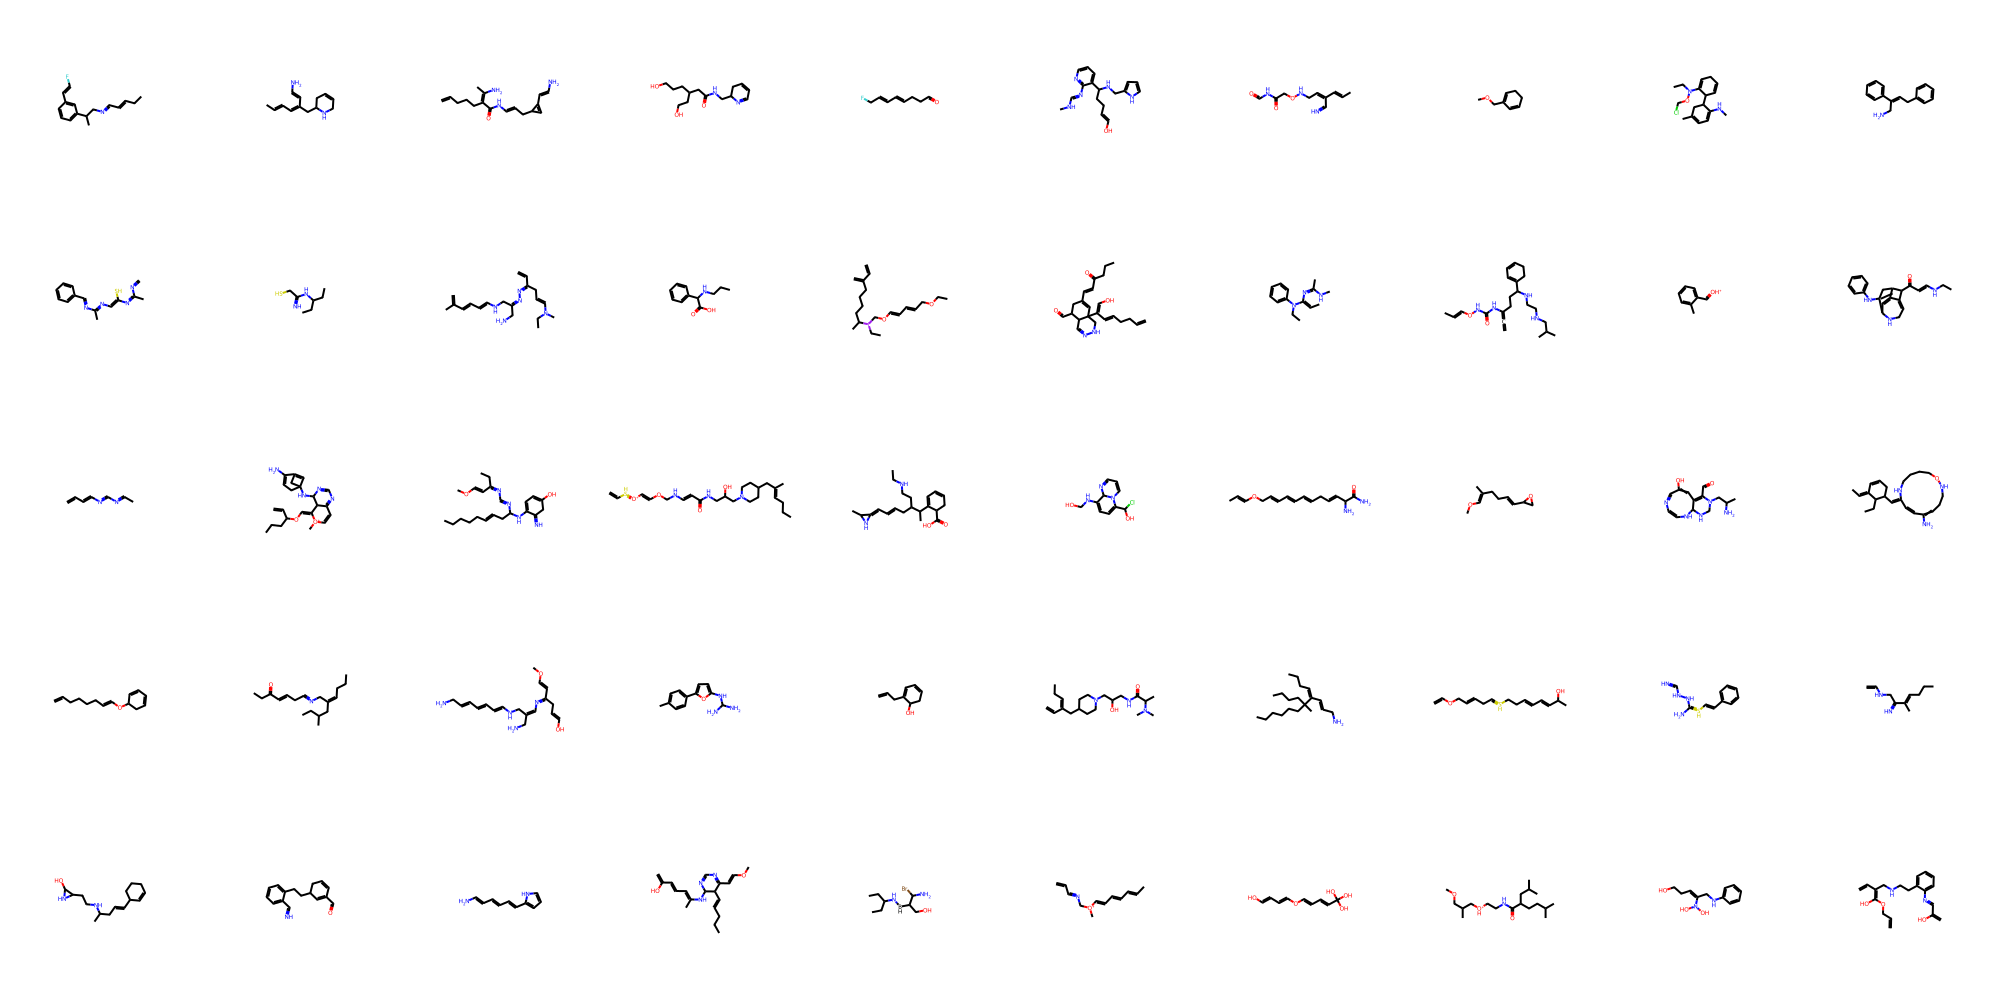

In [693]:
sample_smiles

['cccc=C',
 'CCC(C)CCC(C)CC',
 'ccccc(c)cNc',
 'CCCCC1C(C)CC2NC(CCC)CCCC21',
 'c=cc=c',
 'C=CC(CC)C(C)C(CC)CC(CCC)CCC=CC',
 'c=cccccccc',
 'CC=CCCCCC(C)CC(CCCCCCCC)CC(C)C',
 'C=CC1CCC2CCCC(C1)C2',
 'C=CCCCCCCC',
 'C=CCCC(C)CC(CC)CC',
 'c=cc',
 'ccc(c)c',
 'c=cccc',
 'ccccc(c)c',
 'C=CCC(C)CC1CCCC(C)C(C)CC1CC',
 'c=ccc(cc)cc(c)c',
 'C=CC(C)C(C)C(C)C',
 'c=cc=cc(cc)cccc=c',
 'C=CCCCCC',
 'c=ccccc',
 'c=ccCcc1ccc(c(c)c=cc)c1cc',
 'CCC(C)CCCC=CC',
 'CCCC(CC)C(CC)CCCC(C)CC',
 'ccccccc(cc)cC',
 'CCCCC(C)CC',
 'CCC1CCC(C)CC(C)C1',
 'CC1CC2CC2C2CCC=CC1CC2',
 'CCCCCCC1C(C)CCC(C)CCC1CCC=CC1CC1',
 'CCC(C)C',
 'ccccccc',
 'cc=cc(c)c(c)cccc(c)cc(c)cc',
 'c=cc=cc(c)c=ccccc=c',
 'CCC(CC)CC1CCCC1CC',
 'c=cc=cc',
 'C=CCCC(C)C1NCCC1C',
 'c=ccc(ccc=cc)Cc(cc)ccc(c)c',
 'cc=cc(c)C',
 'C=CC(CC)C1CC(C)CNC2CCCC(CC(C)CC(C)CCC)C21',
 'c=Ccc(c)cc(ccc=cc)c1c=cC1c',
 'c=cccc=ccc',
 'C=CCCC(C)C1CCC(CC(C=CCC)CC)CCC1C',
 'cc=C',
 'CCCC(C)CCC(C)C',
 'CC1CC2C(CN)C12',
 'CC=CC[SCH2]',
 'c=ccc',
 'CC=CCCC',
 'c=cc(c)c',


In [302]:
from evaluation.moses.metrics import get_all_metrics
current_smiles_datasets=['ames']
splits=['_50']
device=torch.device('cpu')
structural_statistic=['nspdk','WL']
metrics_type=['structural']
#leave it blank to compute all the structural structures 
generators=['hiervae','wgan','stgg','moflow','gdss','jtnn']

device=torch.device('cpu')
metrics={}
for generator in generators:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            print(dataset_name+split,generator)
            (train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets),smiles  =get_data(dataset_name+split, return_smiles=True)
            generated_graphs, generated_targets,smiles2=get_generated_data(dataset_name+split, generator_name=generator,return_smiles=True)
            splits_for_auc_roc=[train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets, generated_graphs, generated_targets]
            #metrics=evaluate(train1_graphs, generated_graphs), device,  metrics_type, structural_statistic,*splits_for_auc_roc)
            metrics['dataset']=dataset_name+split
            metrics['generator_name']=generator
            print(metrics)
        

ames_50 hiervae
{'dataset': 'ames_50', 'generator_name': 'hiervae'}
ames_50 wgan


KeyboardInterrupt: 

In [41]:
from evaluation.moses.metrics import get_all_metrics

for generator in ['train1']:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            #print(generator,dataset_name,split )
            (train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets),smiles1 =get_data(dataset_name+split, return_smiles=True)
            generated_graphs, generated_targets=smiles1['train1_smiles'],train1_targets
            mol_metrics=get_all_metrics(gen=generated_graphs,train=list(smiles1['train1_smiles']))
            print(generator,dataset_name,split,mol_metrics)

train1 ames _25 {'valid': 1.0, 'unique@1000': 0.999, 'unique@10000': 0.9992144540455616, 'FCD/Test': 21.781775291678983, 'SNN/Test': 0.3460786905072378, 'Frag/Test': 0.609096242342599, 'Scaf/Test': 0.07181614456792074, 'FCD/TestSF': 22.86709712525912, 'SNN/TestSF': 0.3347151500742827, 'Frag/TestSF': -0.007764708095505224, 'Scaf/TestSF': 0.15573039734059768, 'IntDiv': 0.9115402626448194, 'IntDiv2': 0.8910555622455708, 'Filters': 0.5648075412411626, 'logP': 0.8414846782538974, 'SA': 0.39479570823158266, 'QED': 0.3020678291821059, 'weight': 92.34040517884273, 'Novelty': 0.0007861635220125787}
train1 ames _33 {'valid': 1.0, 'unique@1000': 1.0, 'unique@10000': 1.0, 'FCD/Test': 21.236416889626646, 'SNN/Test': 0.34834962803760744, 'Frag/Test': 0.5781554686180765, 'Scaf/Test': 0.07074550219218434, 'FCD/TestSF': 22.32740778317273, 'SNN/TestSF': 0.33650527514069745, 'Frag/TestSF': -0.0564585395413002, 'Scaf/TestSF': 0.17318521765311345, 'IntDiv': 0.9104997850215626, 'IntDiv2': 0.8916725499146103

In [42]:
from evaluation.moses.metrics import get_all_metrics

for generator in ['train2']:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            #print(generator,dataset_name,split )
            (train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets),smiles1 =get_data(dataset_name+split, return_smiles=True)
            train2_pos_smiles=smiles1['train2_pos_smiles']
            train2_neg_smiles=smiles1['train2_neg_smiles']
            train2_graphs=train2_pos_smiles+train2_neg_smiles
            #train2_targets = np.array([1]*len(train2_pos_smiles) + [0]*len(train2_neg_smiles))
            generated_graphs=train2_graphs
            mol_metrics=get_all_metrics(gen=generated_graphs,train=list(smiles1['train1_smiles']))
            print(generator,dataset_name,split,mol_metrics)

train2 ames _25 {'valid': 1.0, 'unique@1000': 1.0, 'unique@10000': 0.9989531536247056, 'FCD/Test': 20.925845530401126, 'SNN/Test': 0.35017161944077235, 'Frag/Test': 0.5775453373518646, 'Scaf/Test': 0.09539052990468633, 'FCD/TestSF': 22.029602836827685, 'SNN/TestSF': 0.33657932424812037, 'Frag/TestSF': -0.059282118951847984, 'Scaf/TestSF': 0.1758219187605672, 'IntDiv': 0.9099865986374363, 'IntDiv2': 0.8923639507448167, 'Filters': 0.5563988484689871, 'logP': 0.8422316026494058, 'SA': 0.39152390062767095, 'QED': 0.29595233176938956, 'weight': 90.33570975871515, 'Novelty': 0.9986900707361802}
train2 ames _33 {'valid': 1.0, 'unique@1000': 0.997, 'unique@10000': 0.998527679623086, 'FCD/Test': 21.070158683236308, 'SNN/Test': 0.34954836940254636, 'Frag/Test': 0.5906718037471668, 'Scaf/Test': 0.09921941810851997, 'FCD/TestSF': 22.174546107895935, 'SNN/TestSF': 0.3359175579528049, 'Frag/TestSF': -0.03894815366497717, 'Scaf/TestSF': 0.17036759946248248, 'IntDiv': 0.9102878601909401, 'IntDiv2': 0.

In [46]:
from evaluation.moses.metrics import get_all_metrics
from sklearn.utils import shuffle 
for generator in ['train1/2+train2/2']:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            #print(generator,dataset_name,split )
            (train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets),smiles1 =get_data(dataset_name+split, return_smiles=True)
            train2_pos_smiles=smiles1['train2_pos_smiles']
            train2_neg_smiles=smiles1['train2_neg_smiles']
            train2_graphs=shuffle(train2_pos_smiles+train2_neg_smiles)
            train2_targets = np.array([1]*len(train2_pos_smiles) + [0]*len(train2_neg_smiles))
            half=len(train1_graphs)//2
            half2=len(train2_graphs)//2
            train3_graphs=list(smiles1['train1_smiles'][:half]+train2_graphs[:half])
            generated_graphs=train3_graphs
            mol_metrics=get_all_metrics(gen=generated_graphs,train=smiles1['train1_smiles'],test=list(smiles1['train1_smiles']))
            print(generator,dataset_name,split,mol_metrics)

train1/2+train2/2 ames _25 {'valid': 1.0, 'unique@1000': 1.0, 'unique@10000': 1.0, 'FCD/Test': 0.7904572060235608, 'SNN/Test': 0.7514531218194924, 'Frag/Test': 0.9874218010905594, 'Scaf/Test': 0.8838672479875699, 'FCD/TestSF': 22.556825322699517, 'SNN/TestSF': 0.33532934654035473, 'Frag/TestSF': -0.025246925807700826, 'Scaf/TestSF': 0.16665821905137568, 'IntDiv': 0.910043830533207, 'IntDiv2': 0.8899929747197383, 'Filters': 0.5621069182389937, 'logP': 0.07561705939641397, 'SA': 0.029469839338340794, 'QED': 0.008785631679633997, 'weight': 2.092928590661392, 'Novelty': 0.5007861635220126}


KeyboardInterrupt: 

In [6]:
current_smiles_datasets=['ames', 'bbb_martins', 'cyp1a2_veith', 'cyp2c19_veith','herg_karim','lipophilicity_astrazeneca']
splits=['_25','_33','_40','_50']
device=torch.device('cpu')
structural_statistic=['nspdk','WL']
metrics_type=['nn', 'structural','molecular', 'auc_roc']
#leave it blank to compute all the structural structures 
generators=['hiervae','wgan','stgg','moflow','gdss','jtnn']

In [ ]:
from sklearn.utils import shuffle
#draw generated data
dataset_name='ames'
split='_25'
generator_name='wgan'
collected_molecules=[]
for dataset_name in ['cyp1a2_veith']:
    for split in ['_33']:
        #(train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets),smiles =get_data(dataset_name+split, return_smiles=True)
        generated_graphs, generated_targets,smiles=get_generated_data(dataset_name+split, generator_name=generator_name,return_smiles=True)
        #draw_graphs(generated_graphs[12:18],num_per_line=8)
        #print(f'Generated by {generator_name} from {dataset_name+split}')
        collected_molecules=collected_molecules+smiles_to_mol(shuffle(smiles))
Draw.MolsToGridImage(collected_molecules,molsPerRow=5
                     )

In [ ]:
Draw.MolsToGridImage(collected_molecules,molsPerRow=8
                     )

In [13]:
import pandas as pd
test=pd.read_csv('out.csv')

In [14]:
only_25=test.loc[(test.dataset=='ames_50') | (test.dataset=='bbb_martins_50') | \
                      (test.dataset=='herg_karim_50') | (test.dataset=='cyp1a2_veith_50') \
                        | (test.dataset=='cyp2c19_veith_50')| \
                       (test.dataset=='lipophilicity_astrazeneca_50')   ]

Text(0.5, 1.0, 'Molecular Weight')

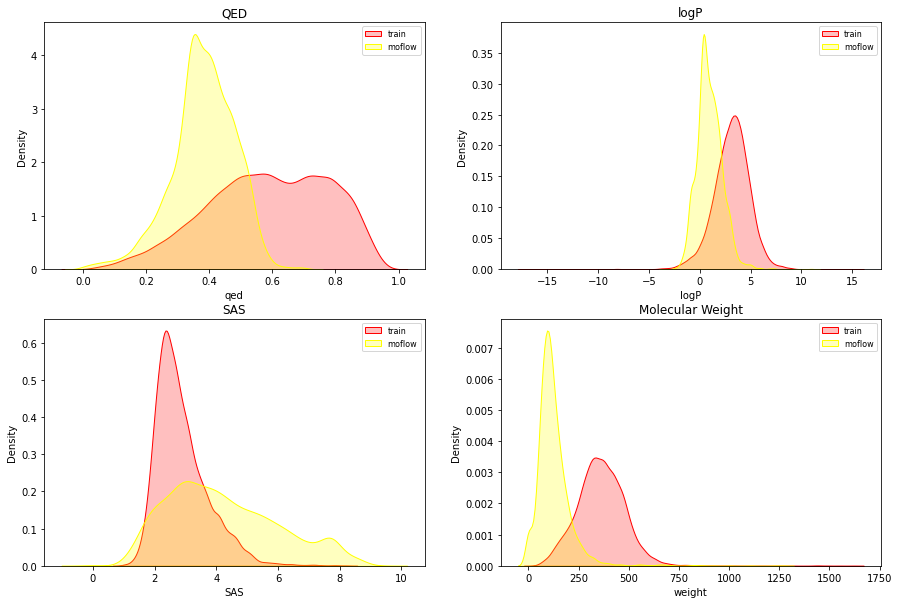

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings 
warnings.filterwarnings("ignore") 
 
generator_name='moflow'
fig,ax=plt.subplots(2,2,figsize=(15, 10))

sns.kdeplot(only_25[only_25.generator=='original']['qed'], color="red", shade=True,ax=ax[0,0])
sns.kdeplot(only_25[only_25.generator==generator_name]['qed'], color="yellow", shade=True,ax=ax[0,0])
#sns.kdeplot(only_25[only_25.generator=='jtnn']['qed'], color="teal", shade=True,ax=ax[0,0])


ax[0,0].legend(labels=['train',generator_name],fontsize=8)
ax[0,0].set_title('QED')



sns.kdeplot(only_25[only_25.generator=='original']['logP'], color="red", shade=True,ax=ax[0,1])
sns.kdeplot(only_25[only_25.generator==generator_name]['logP'], color="yellow", shade=True,ax=ax[0,1])
ax[0,1].legend(labels=['train',generator_name],fontsize=8)
ax[0,1].set_title('logP')


sns.kdeplot(only_25[only_25.generator=='original']['SAS'], color="red", shade=True,ax=ax[1,0])
sns.kdeplot(only_25[only_25.generator==generator_name]['SAS'], color="yellow", shade=True,ax=ax[1,0])
ax[1,0].legend(labels=['train',generator_name],fontsize=8)
ax[1,0].set_title('SAS')


sns.kdeplot(only_25[only_25.generator=='original']['weight'], color="red", shade=True,ax=ax[1,1])

sns.kdeplot(only_25[only_25.generator==generator_name]['weight'], color="yellow", shade=True,ax=ax[1,1])

ax[1,1].legend(labels=['train',generator_name],fontsize=8)
ax[1,1].set_title('Molecular Weight')


In [24]:
list=[1,2,3,4]
list[:4]


[1, 2, 3, 4]